# BoW's of SIFT descriptors for classification

In [ ]:
from os import listdir
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import cv2

from skimage.io import imread
from skimage.transform import resize
from sklearn.preprocessing import normalize
from sklearn.svm import SVC

# Imports for training a classifier with grid search
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


In [ ]:
# Find the name of each class
base_path = "/content/.../caltech-101"
class_names = listdir(base_path)[:5]
print("Num of classes:", len(class_names))

Num of classes: 5


In [ ]:
import os
# Define a base directory

class_names = os.listdir(base_path)[:5]
class_names.sort()
class_freqs = np.array([min(len(os.listdir(os.path.join(base_path, class_id))), 40) for class_id in class_names])

print(f"{len(class_names)} classes found.")
print(class_names)
print(class_freqs)

5 classes found.
['accordion', 'airplanes', 'ant', 'barrel', 'beaver']
[40 40 40 40 40]


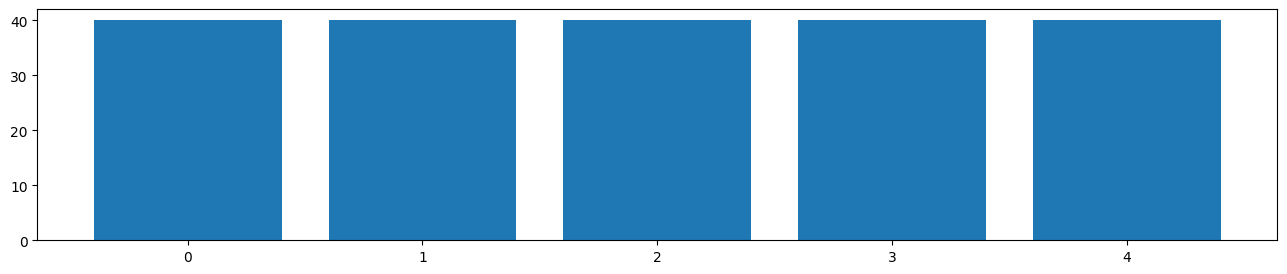

In [ ]:
# Plot a histogram
plt.figure(figsize=(16, 3))
plt.bar(range(len(class_freqs)), class_freqs)
plt.show()

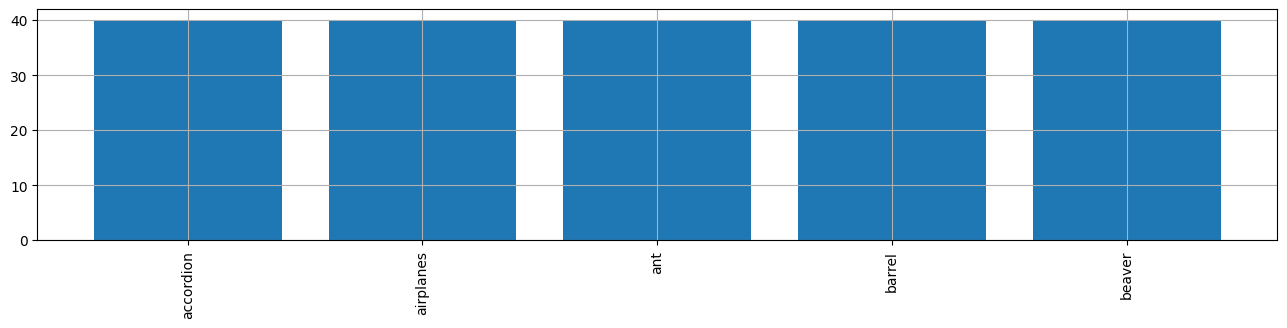

In [ ]:
# Remove classes with more than 60 instances
#from itertools import compress
#to_Keep = class_freqs <= 60
#class_names = list(compress(class_names, to_Keep))
#class_freqs = class_freqs[to_Keep]

plt.figure(figsize=(16, 3))
plt.bar(range(len(class_freqs)), class_freqs)
plt.xticks(range(len(class_freqs)), class_names, rotation='vertical')
plt.grid()
plt.show()

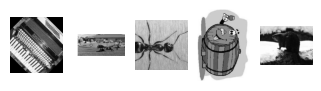

In [ ]:
# Show one example per class
plt.figure(figsize=(20, 10))
for it_class, class_id in enumerate(class_names):
    class_files = os.listdir(os.path.join(base_path, class_id))
    img = cv2.imread(os.path.join(base_path, class_id, class_files[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.subplot(5, 25, it_class+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
# Get the full path for all files
all_files_names = []
all_files_classes = []
for it_class, class_id in enumerate(class_names):
    class_files = os.listdir(os.path.join(base_path, class_id))[:40]
    for file_name in class_files:
        all_files_names.append(os.path.join(base_path, class_id, file_name))
        all_files_classes.append(it_class)
all_files_classes = np.array(all_files_classes)

In [ ]:
# Split training and test sets
names_train, names_test, y_train, y_test = train_test_split(all_files_names, all_files_classes, test_size=0.1)

print(y_train.shape)
print(y_test.shape)

(180,)
(20,)


In [ ]:
def compute_SIFT(file_path):
    img = cv2.imread(file_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    _, desc = sift.detectAndCompute(gray, None)
    desc = np.clip(normalize(desc), 0.0, 0.2)
    return(normalize(desc))

In [ ]:
from random import sample

train_SIFTS = []
for file_name in sample(names_train, len(names_train)): # Use random subset of training samples
    train_SIFTS.extend(compute_SIFT(file_name))
    if len(train_SIFTS) >= 50_000:
        break

train_SIFTS = np.array(train_SIFTS)

Inertia: 12452.669921875


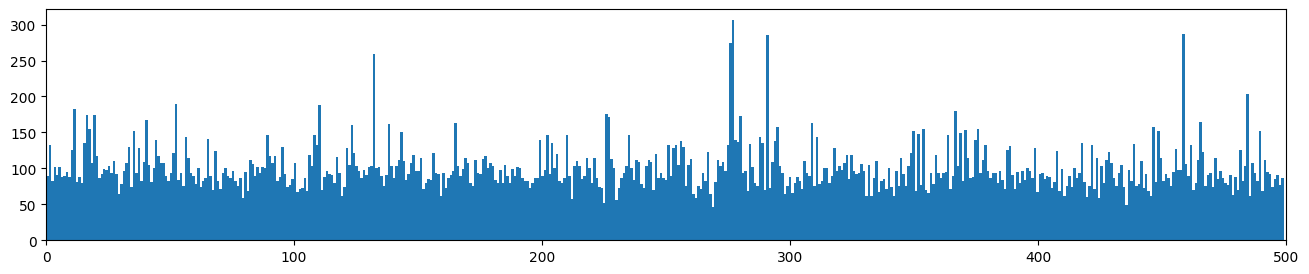

In [ ]:
# Train a visual dictionary
from sklearn.cluster import KMeans

num_clusters = 500
kmeans = KMeans(n_clusters=num_clusters, n_init=10).fit(train_SIFTS)
print(f"Inertia: {kmeans.inertia_}")

# Show frequency distribution of words
plt.figure(figsize=(16, 3))
plt.hist(kmeans.labels_, num_clusters)
plt.xlim(0, num_clusters)
plt.show()

In [ ]:
# Read an image, estimate its SIFT descriptors and BoW representation
def get_visual_words(file_path):
    SIFTS = compute_SIFT(file_path)
    v_words = kmeans.predict(SIFTS)
    return(v_words)

In [ ]:
# Compute the BOW representation for all the training set
BOW_train = np.zeros((len(names_train), num_clusters))
bins = np.arange(0, num_clusters+1)
for it_file, file_name in enumerate(names_train):
    v_words = get_visual_words(file_name)
    BOW_train[it_file], _ = np.histogram(v_words, bins, density=True)

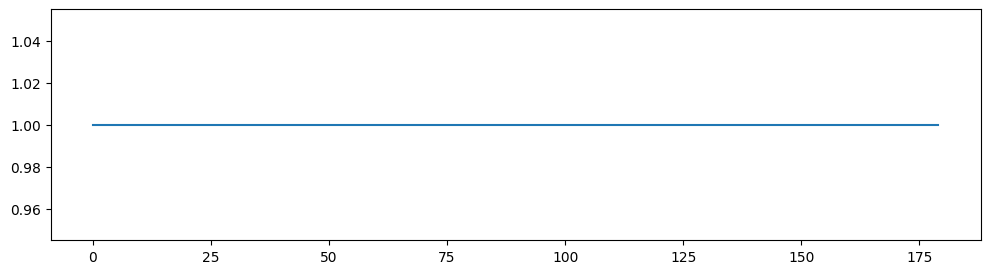

(180, 500)
(180,)


In [ ]:
# Show all BOW representations sum up to one
plt.figure(figsize=(12, 3))
plt.plot(BOW_train.sum(axis=1))
plt.show()

print(BOW_train.shape)
print(y_train.shape)

In [ ]:
# Compute the BOW representation for all the test set
BOW_test = np.zeros((len(names_test), num_clusters))
bins = np.arange(0, num_clusters+1)
for it_file, file_name in enumerate(names_test):
    v_words = get_visual_words(file_name)
    BOW_test[it_file], _ = np.histogram(v_words, bins, density=True)

In [ ]:
# Define grid search parameters **********************************************
hyperparams = {'kernel': ['linear', 'poly', 'rbf'],
               'C': [0.01, 0.1, 1.0, 10, 100],
               'degree': [1, 2, 3, 4],
               'gamma': ['auto', 'scale'],
               'coef0': [1/4, 1/2, 1, 2]}
hyperparams

{'kernel': ['linear', 'poly', 'rbf'],
 'C': [0.01, 0.1, 1.0, 10, 100],
 'degree': [1, 2, 3, 4],
 'gamma': ['auto', 'scale'],
 'coef0': [0.25, 0.5, 1, 2]}

In [ ]:
# Create and train the classifiers with grid search
gs = GridSearchCV(SVC(), hyperparams, verbose=True, n_jobs=-1)
gs.fit(BOW_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1.0, 10, 100],
                         'coef0': [0.25, 0.5, 1, 2], 'degree': [1, 2, 3, 4],
                         'gamma': ['auto', 'scale'],
                         'kernel': ['linear', 'poly', 'rbf']},
             verbose=True)

**Tiempo de Ejecución**: 32 segundos

In [ ]:
# Print info about best score and best hyperparameters
print(f"Best score: {gs.best_score_:.3f}")
print(f"Best params: {gs.best_params_}")

Best score: 0.700
Best params: {'C': 1.0, 'coef0': 0.25, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}


In [ ]:
# Evaluate on the test set
best_svm = gs.best_estimator_

print(f"Train mean accuracy: {best_svm.score(BOW_train, y_train):.3f}")
print(f"Test mean accuracy: {best_svm.score(BOW_test, y_test):.3f}")

Train mean accuracy: 0.928
Test mean accuracy: 0.650


[[4 0 0 1 1]
 [0 3 0 0 0]
 [0 0 2 0 0]
 [0 0 0 1 5]
 [0 0 0 0 3]]


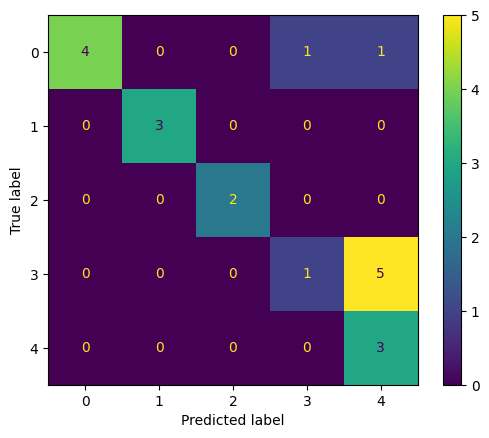

In [ ]:
# Confusion matrix
predicted_labels = best_svm.predict(BOW_test)
confusion_matrix = confusion_matrix(y_test, predicted_labels)
print(confusion_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix)
# Dibujar el gráfico de la matriz de confusión
cm_display.plot()
# Mostrar el gráfico
plt.show()


In [ ]:
# Gradient Boosting *************************************************

# Define grid search parameters
hyperparams = {'learning_rate': [0.001, 0.01, 0.1],
               'n_estimators': [2, 5, 10],
               'max_depth': range(2, 7),
               'min_samples_split': range(2, 7),
               'min_samples_leaf': range(1, 6, 2),
               'max_features': [None, 'sqrt', 'log2']}
hyperparams

{'learning_rate': [0.001, 0.01, 0.1],
 'n_estimators': [2, 5, 10],
 'max_depth': range(2, 7),
 'min_samples_split': range(2, 7),
 'min_samples_leaf': range(1, 6, 2),
 'max_features': [None, 'sqrt', 'log2']}

In [ ]:
# Create and train the classifiers with grid search
gs_model = GridSearchCV(GradientBoostingClassifier(), hyperparams, verbose=True, n_jobs=3)
gs_model.fit(BOW_train, y_train)

Fitting 5 folds for each of 2025 candidates, totalling 10125 fits


GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=3,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': range(2, 7),
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': range(1, 6, 2),
                         'min_samples_split': range(2, 7),
                         'n_estimators': [2, 5, 10]},
             verbose=True)

**Tiempo de Ejecución**: tardó 26 minutos

In [ ]:
# Print info about best score and best hyperparameters
print(f"Best score: {gs_model.best_score_:.3f}")
print(f"Best params: {gs_model.best_params_}")

Best score: 0.672
Best params: {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 10}


In [ ]:
# Evaluate on the test set
best_classifier = gs_model.best_estimator_

print(f"Train mean accuracy: {best_classifier.score(BOW_train, y_train):.3f}")
print(f"Test mean accuracy: {best_classifier.score(BOW_test, y_test):.3f}")

Train mean accuracy: 1.000
Test mean accuracy: 0.550


[[4 1 1 0 0]
 [0 3 0 0 0]
 [0 1 1 0 0]
 [0 1 2 1 2]
 [0 1 0 0 2]]


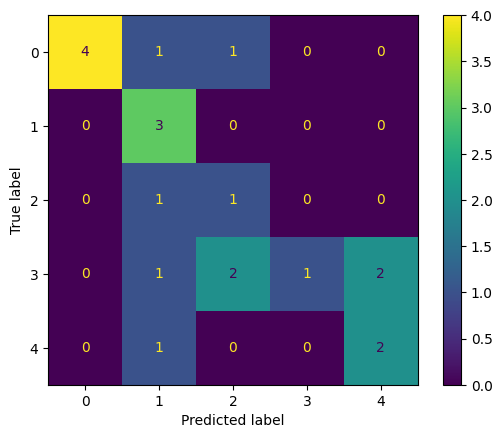

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Confusion matrix
predicted_labels = best_classifier.predict(BOW_test)
confusion_matrix = confusion_matrix(y_test, predicted_labels)
print(confusion_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix)
# Dibujar el gráfico de la matriz de confusión
cm_display.plot()
# Mostrar el gráfico
plt.show()
